# House Price Prediction
Ett påhittat dataset med samlad information om 10.000 boenden som ska kunna försutse priser
## Fråga:
### Kan vi förutsäga priset på ett boende?

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("house_prices_dataset.csv")

df.describe()

,square_feet,num_rooms,age,distance_to_city(km),price
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1999.147496,4.49510,49.516900,15.362148,263011.571609
std,501.021194,1.71116,28.992336,8.325101,98336.945117
min,500.000000,2.00000,0.000000,1.000161,-95613.138249
25%,1663.704735,3.00000,24.000000,8.121636,196791.510684
50%,1998.702512,4.00000,49.000000,15.403146,262497.361236
75%,2335.540444,6.00000,75.000000,22.447530,330445.581908
max,3963.118853,7.00000,99.000000,29.993892,660168.255648


## Här upptäcke vi att det finns minus värden på Price kolumnen

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   square_feet           10000 non-null  float64
 1   num_rooms             10000 non-null  int64  
 2   age                   10000 non-null  int64  
 3   distance_to_city(km)  10000 non-null  float64
 4   price                 10000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 390.8 KB


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

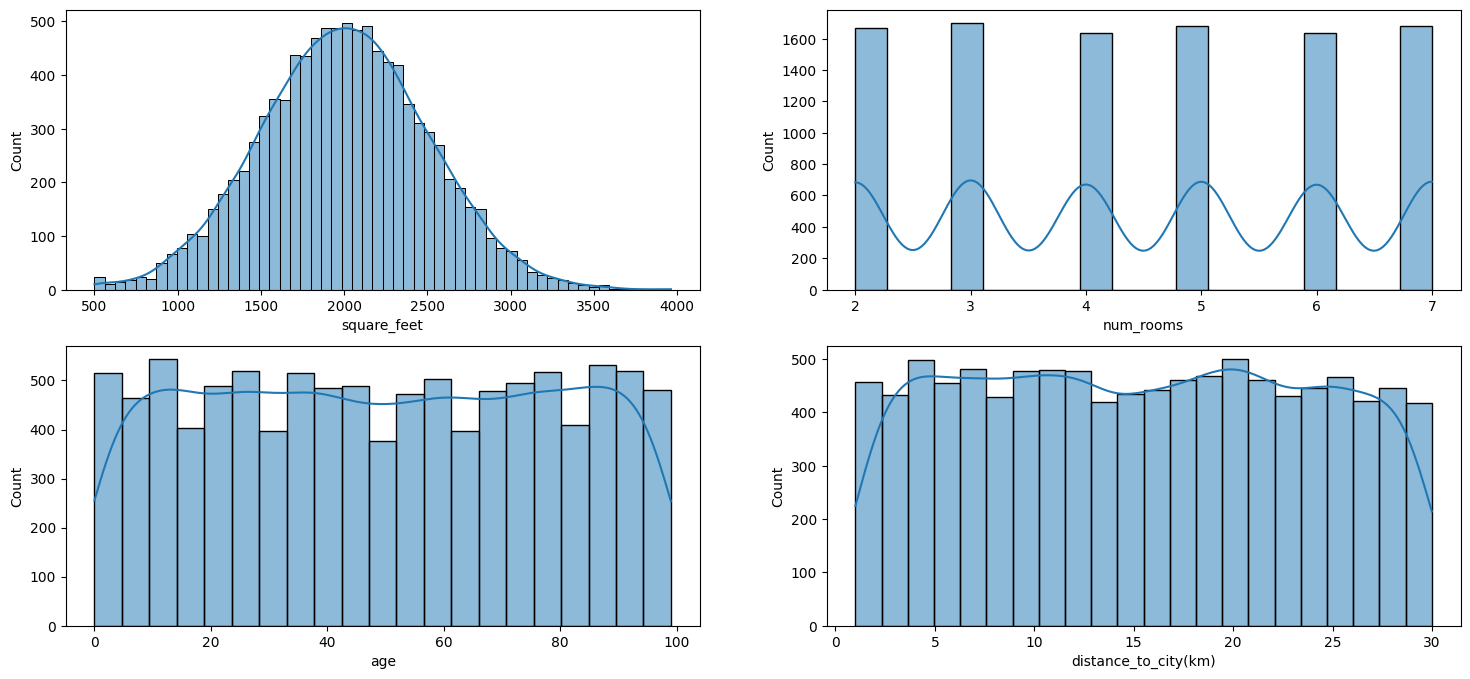

In [5]:
features = df.columns.drop('price')

n_features = len(features)
n_cols = 2
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,8))

for i, feature in enumerate(features):
    row = i // n_cols
    col = i % n_cols

    feature_data = df[feature].dropna()

    sns.histplot(feature_data, kde= True, ax = axes[row, col])

plt.show()

## När vi tittade på histogrammen så ser vi inget som vi tycker ser underligt ut

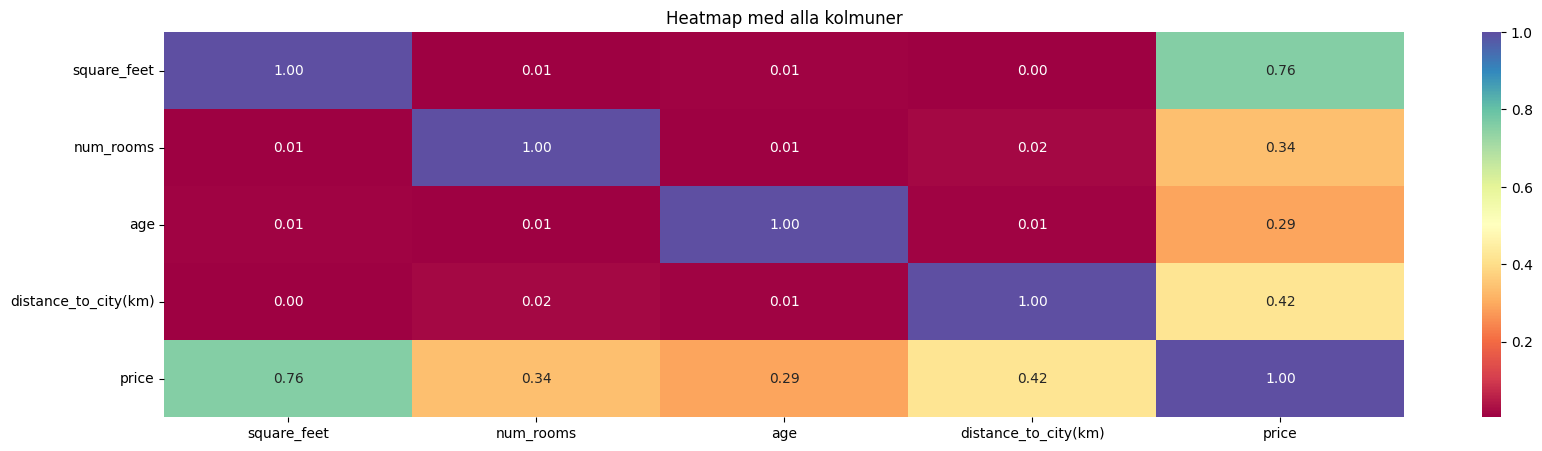

price                   1.000000
square_feet             0.756545
distance_to_city(km)    0.418217
num_rooms               0.335230
age                     0.290799
Name: price, dtype: float64


In [6]:
corr_matrix = df.corr()

plt.figure(figsize = (20,5))
sns.heatmap(corr_matrix.abs(), annot = True, fmt = '0.2f', cmap = 'Spectral')
plt.title("Heatmap med alla kolmuner")
plt.show()

print(corr_matrix['price'].abs().sort_values(ascending = False))

## Efter vår heatmap bestämmer vi att vi vill använda square_feet och distance_to_city(km) för att träna våran model

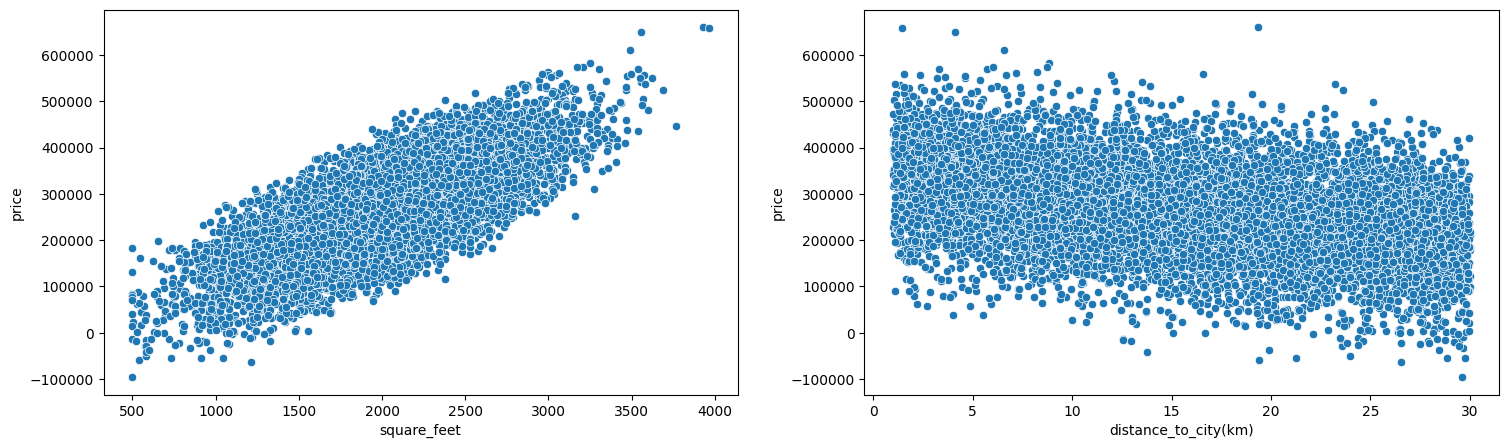

In [7]:
#df = df[df['price'] > 0] # tabort negativa priser
#df = df[df['price'] < 500000] # jämna ut på toppen för det vi tog bort nedåt (inget av dessa två hjälpte)

top_corr_features = ['square_feet', 'distance_to_city(km)']

fig, axes = plt.subplots(1, 2, figsize = (18, 5))

for i, feature in enumerate(top_corr_features):
    sns.scatterplot(x = df[feature], y = df['price'], ax = axes[i])
    axes[i].set_xlabel(feature)


plt.show()

## Här ville vi se hur alla priser la sig tillsammans med våra utvalda kolumner. Man ser til exempel att det finns några som är väldigt utstickande och höga. Då provade vi att ta bort både minusvärderna och dom högsta, vi tog bort lika mycker upp som ned.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor

In [9]:
df = df[df['price'] > 0] # tabort negativa priser
df = df[df['price'] < 500000] # jämna ut på toppen för det vi tog bort nedåt (inget av dessa två hjälpte)

#x = df[top_corr_features] # med endast square_feet och distance_to_city
x = df[features] # om man tar in alla värden så får man mycket bättre siffror
y = df['price']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

model = LinearRegression()

model.fit(x_train_scaled, y_train)



,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Vi valde först att träna vår model med dom valda kolumnerna, square_feet och distance_to_city, men värkte att vi fick väldigt höga siffror. Vår rmse hamnade runt 50.000 och r2 blev 0.75, vilket är mycket om man jämnför med 100.000 men inte så mycket om man har ett boende för 600.000. Men om man tittar procentuellt så var det inte så mycket, då var det bara ca 18% felberäkning.

In [10]:
y_pred = model.predict(x_test_scaled)

y_true = y_test

mse = mean_squared_error(y_test, y_pred)

rmse = mse ** 0.5

r2 = r2_score(y_test, y_pred)

mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print("Rmse: ", rmse)
print("R2: ", r2)
print("Procent: ", mape, "%") # procent fel som räknas

Rmse:  19721.23721272762
R2:  0.9564814024192521
Procent:  7.718904882780412 %


## Här använde vi alla kolumner och fick direkt bättre uträckning. Bara ca 19.000 i felberäkning vilket blir 7%

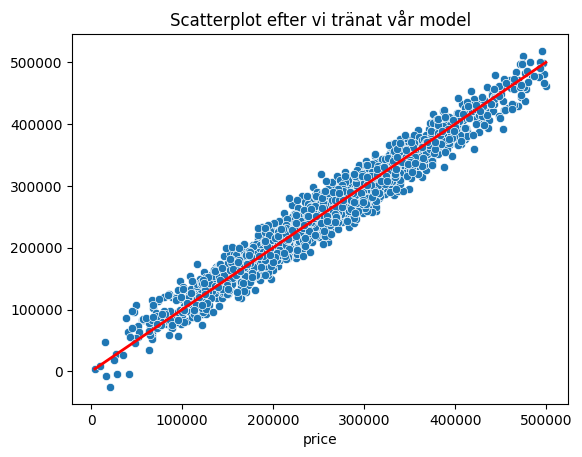

In [11]:
sns.scatterplot(x = y_test, y = y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)

plt.title("Scatterplot efter vi tränat vår model")
plt.show()

<Axes: xlabel='price', ylabel='Count'>

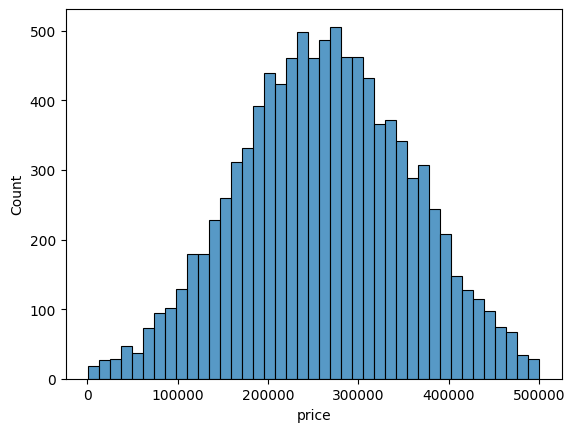

In [12]:
sns.histplot(data = df, x = 'price')

In [13]:
model = RandomForestRegressor(n_estimators = 100, random_state = 42)

model.fit(x_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
y_pred_again = model.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred_again)

rmse = mse ** 0.5

r2 = r2_score(y_test, y_pred_again)

print("Rmse: ", rmse)
print("R2: ", r2)

Rmse:  22598.651446972115
R2:  0.9428558699908899


## När vi bara använde två kolmner var RandomForestRegressor ännu högre än vår linjära. Så när vi valde att använda alla 4 blev det direkt ett bättre värde här också.

# Slutsats
- Det var bättre med alla värden än bara 2
- Att 19.000 kan låta mycket, men är en siffra som är rimlig för vårt dataset
- Vi tyckte nog den linjära regresionen var bättre för det här datasetet eftersom det var ett lite mindre dataset
- Vi lärde oss att vår hypotes angående dom negativa priserna inte hjälpte som vi var övertygade att dom skulle
- Ibland behöver man inte krångla till det i onödan